#HW1 - Data Exploration and Preparation

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

## Loading the dataset

In [ ]:
url_base= "hw1_final_data.csv"
df = pd.read_csv(url_base, header=0)

In [ ]:
#Initialize variables

train_df, test_df = train_test_split(df, test_size=0.2, random_state=69)

train_partial_df = train_df[['PCR_01', 'PCR_02', 'spread']]
test_partial_df = test_df[['PCR_01', 'PCR_02', 'spread']]

X_train = train_partial_df[['PCR_01', 'PCR_02']].to_numpy()
Y_train = train_partial_df[['spread']].to_numpy()

X_test = test_partial_df[['PCR_01', 'PCR_02']].to_numpy()
Y_test = test_partial_df[['spread']].to_numpy()

train_df_all_feat = train_df.copy()
train_df_all_feat.drop(columns=['risk', 'spread'], axis=1, inplace=True)
X_all_feat_train = train_df_all_feat.to_numpy()
Y_all_feat_train = train_df[['risk']].to_numpy()

test_df_all_feat=test_df.copy()
test_df_all_feat.drop(columns=['risk', 'spread'], axis=1, inplace=True)
X_all_feat_test = test_df_all_feat.to_numpy()
Y_all_feat_test = test_df[['risk']].to_numpy()

part 1

Q1

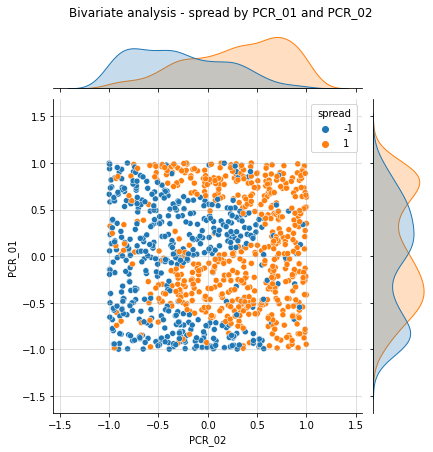

In [ ]:
palette = sns.color_palette('tab10', 2)

g = sns.jointplot(y='PCR_01', x='PCR_02', data=train_partial_df, hue='spread', palette=palette)
g.fig.suptitle("Bivariate analysis - spread by PCR_01 and PCR_02", y=1.04)
g.ax_joint.grid(alpha=0.5)

Q2

In [ ]:
def visualize_clf(clf, X, Y, title, 
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap
    
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
        
    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)
    
    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()
   

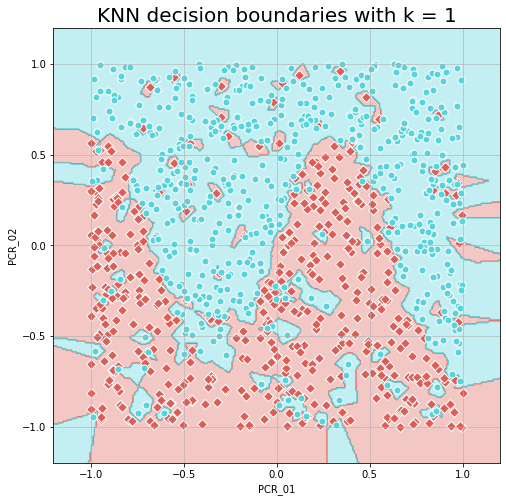

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, Y_train)

visualize_clf(knn1, X_train, Y_train, "KNN decision boundaries with k = 1", "PCR_01", "PCR_02")

Q3

In [ ]:
def calculatTheBestKNN(X_train, Y_train):
  k_array = list(range(1, 20, 2)) + list(range(20, 871, 85))
  
  results_train = dict()
  results_val = dict()

  for k in k_array:
      knn = KNeighborsClassifier(n_neighbors=k)
      cv_results = cross_validate(knn, X_train, Y_train, cv=8, return_train_score=True)
      results_val[k] = cv_results['test_score'].mean()
      results_train[k] = cv_results['train_score'].mean()
  
  g = sns.lineplot(x=list(results_val.keys()), y=list(results_val.values()), label="Validation Score", color='g')
  g = sns.lineplot(x=list(results_train.keys()), y=list(results_train.values()), label="Training Score", color='b')
  plt.title('Validation curve - mean training and validation accuracy as a function of k')
  plt.xlabel('Number of neighbors - k')
  plt.ylabel('Score')
  plt.legend(loc='best')
  plt.grid(alpha=0.75)
  plt.show()

  best_k = max(results_val, key=results_val.get)
  print("Best k is:", best_k)
  print("\nMean validation accuracy of model with best k:", results_val[best_k])
  print("Mean train accuracy of model with best k:", round(results_train[best_k], 3))

  return best_k

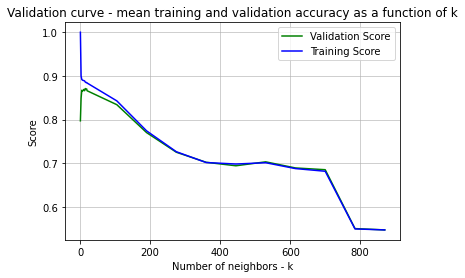

Best k is: 15

Mean validation accuracy of model with best k: 0.871
Mean train accuracy of model with best k: 0.886


In [ ]:
#Q3

best_k = calculatTheBestKNN(X_train, Y_train)

Q4

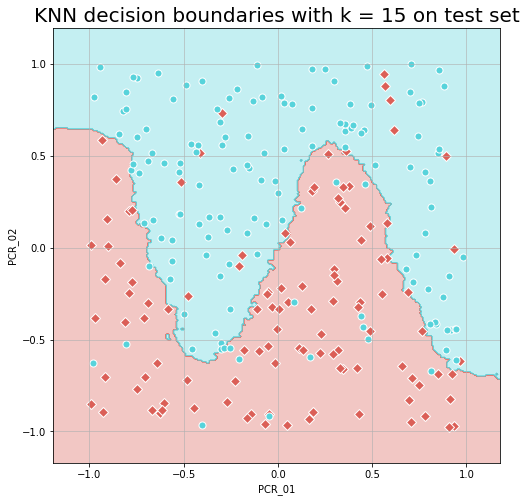

Test set score of KNN model with best k: 0.856


In [ ]:
#Q4

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, Y_train)

visualize_clf(best_knn, X_test, Y_test, "KNN decision boundaries with k = " + str(best_k) + " on test set", "PCR_01", "PCR_02")

print("Test set score of KNN model with best k:", best_knn.score(X_test, Y_test))

Q5

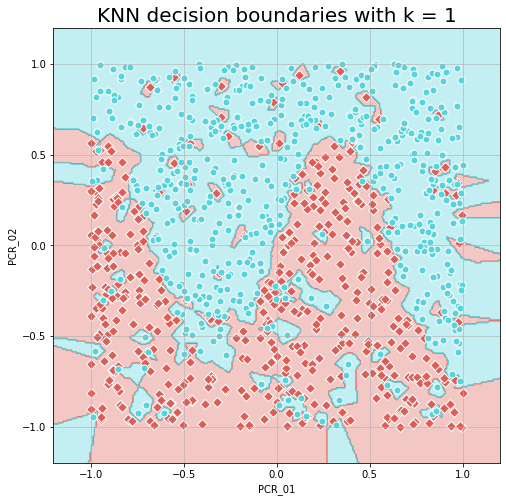

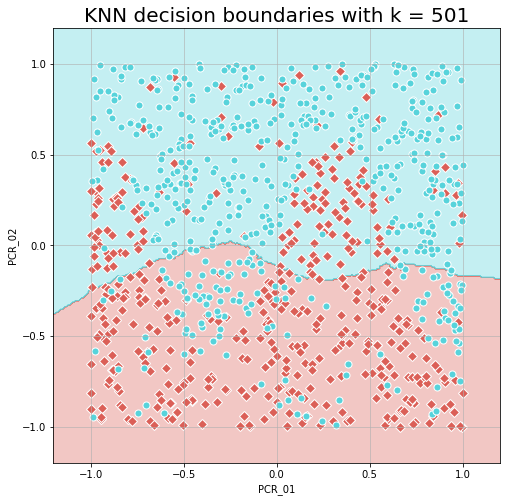

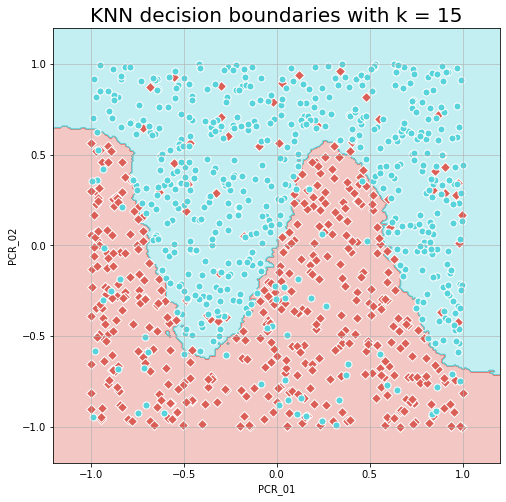

Train set score with k = 1: 1.0
Test set score with k = 1: 0.796

Train set score with k = 501: 0.695
Test set score with k = 501: 0.7

Train set score with best k: 0.885
Test set score with best k: 0.856


In [ ]:
#Q5
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_1.fit(X_train, Y_train)

knn_501 = KNeighborsClassifier(n_neighbors=501)
knn_501.fit(X_train, Y_train)

visualize_clf(knn1, X_train, Y_train, "KNN decision boundaries with k = 1", "PCR_01", "PCR_02")
visualize_clf(knn_501, X_train, Y_train, "KNN decision boundaries with k = 501", "PCR_01", "PCR_02")
visualize_clf(best_knn, X_train, Y_train, "KNN decision boundaries with k = " + str(best_k), "PCR_01", "PCR_02")

print("Train set score with k = 1:", knn1.score(X_train, Y_train))
print("Test set score with k = 1:", knn1.score(X_test, Y_test))

print("\nTrain set score with k = 501:", knn_501.score(X_train, Y_train))
print("Test set score with k = 501:", knn_501.score(X_test, Y_test))

print("\nTrain set score with best k:", best_knn.score(X_train, Y_train))
print("Test set score with best k:", best_knn.score(X_test, Y_test))

Q6

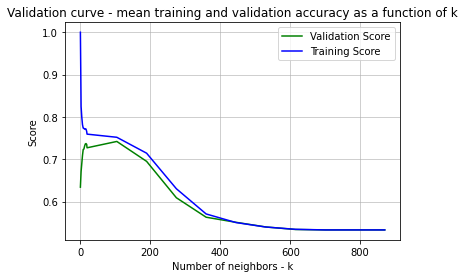

Best k is: 105

Mean validation accuracy of model with best k: 0.742
Mean train accuracy of model with best k: 0.752

Train set score with best k: 0.753
Test set score with best k: 0.76


In [ ]:
#Q6

best_k_all_feat = calculatTheBestKNN(X_all_feat_train,Y_all_feat_train)

best_knn_all_feat = KNeighborsClassifier(n_neighbors=best_k_all_feat)
best_knn_all_feat.fit(X_all_feat_train, Y_all_feat_train)

print("\nTrain set score with best k:", best_knn_all_feat.score(X_all_feat_train, Y_all_feat_train))
print("Test set score with best k:", best_knn_all_feat.score(X_all_feat_test, Y_all_feat_test))

PART 2

Q7

Decision Tree - Train Score: 0.787


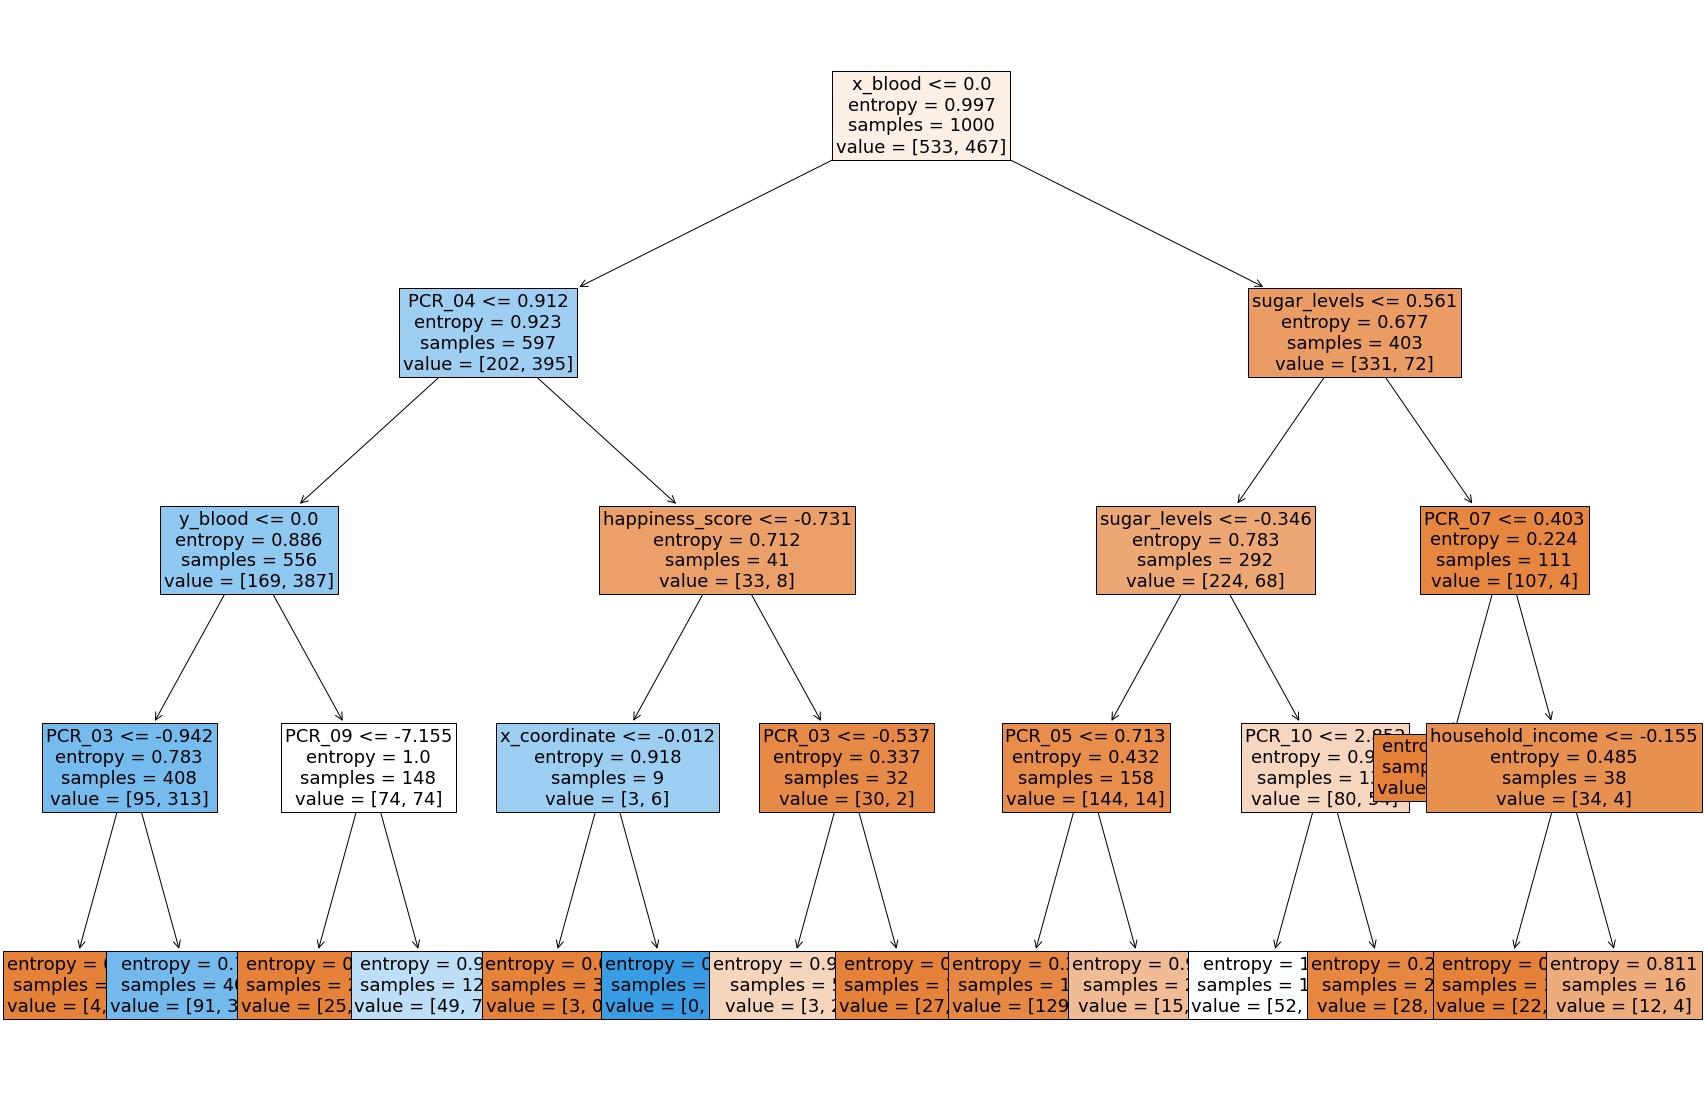

In [ ]:
#Q7

fig = plt.figure(figsize=(30, 20))
decision_tree = DecisionTreeClassifier(max_depth=4, criterion="entropy")
decision_tree.fit(X_all_feat_train, Y_all_feat_train)

_ = plot_tree(decision_tree, feature_names=list(train_df_all_feat.columns), fontsize=18, filled=True)
print("Decision Tree - Train Score:", decision_tree.score(X_all_feat_train, Y_all_feat_train))


Q8

In [ ]:
#Q8
from sklearn.model_selection import GridSearchCV

param_dict = {'max_depth': list(range(1, 20, 2)), 'min_samples_leaf': list(range(1, 61, 5))}
grid = GridSearchCV(estimator=DecisionTreeClassifier(criterion="entropy"), param_grid=param_dict, cv=8, n_jobs=1,
                    return_train_score=True)
_ = grid.fit(X_all_feat_train, Y_all_feat_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'max_depth': 7, 'min_samples_leaf': 21}
Best score: 0.805


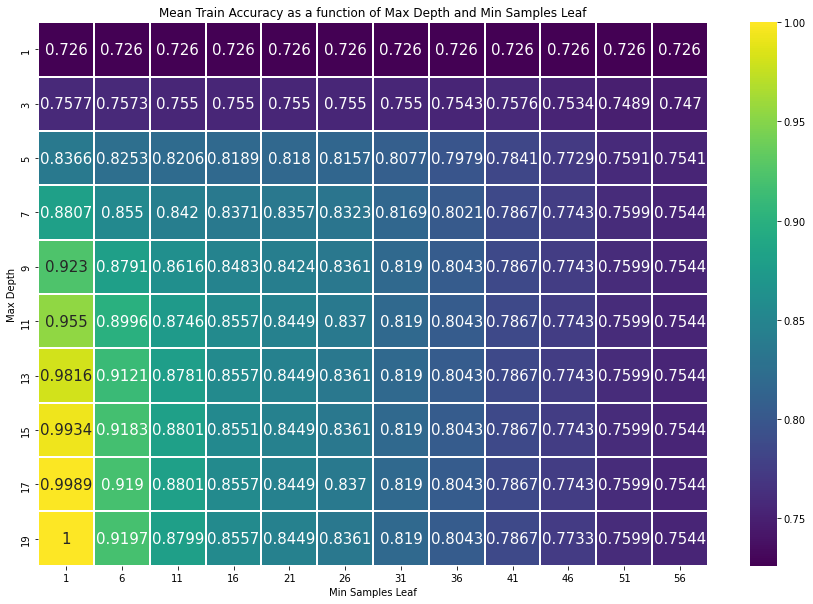

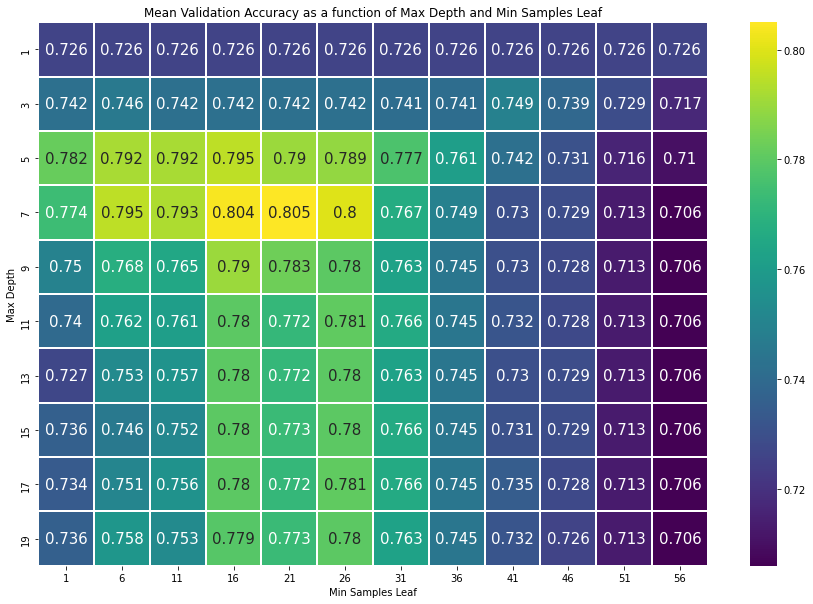

In [ ]:
tune_train = pd.pivot_table(pd.DataFrame(grid.cv_results_),
                            values='mean_train_score', index='param_max_depth', columns='param_min_samples_leaf')

fig, ax = plt.subplots(figsize=(15, 10))
train_subplot = sns.heatmap(tune_train, annot=True, linewidths=1, ax=ax, fmt='.4g', cmap='viridis', annot_kws={'size': 15}, xticklabels=True, yticklabels=True)
plt.title("Mean Train Accuracy as a function of Max Depth and Min Samples Leaf")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Max Depth")
plt.show()

tune_test = pd.pivot_table(pd.DataFrame(grid.cv_results_),
                           values='mean_test_score', index='param_max_depth', columns='param_min_samples_leaf')

fig, ax = plt.subplots(figsize=(15, 10))
test_subplot = sns.heatmap(tune_test, annot=True, linewidths=1, ax=ax, fmt='.4g', cmap='viridis',annot_kws={'size': 15},xticklabels=True, yticklabels=True)
plt.title("Mean Validation Accuracy as a function of Max Depth and Min Samples Leaf")
plt.xlabel("Min Samples Leaf")
plt.ylabel("Max Depth")

plt.show()

Q9

In [ ]:
decision_tree = DecisionTreeClassifier(max_depth=grid.best_params_['max_depth'], min_samples_leaf=grid.best_params_['min_samples_leaf'] ,criterion="entropy")
decision_tree.fit(X_all_feat_train, Y_all_feat_train)

print("Decision Tree - Train Score:", decision_tree.score(X_all_feat_train, Y_all_feat_train))
print("Decision Tree - Test Score:", decision_tree.score(X_all_feat_test, Y_all_feat_test))

Decision Tree - Train Score: 0.836
Decision Tree - Test Score: 0.84


PART 3

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)

        # TODO: complete the loss calculation
        loss = norm **2 + C * np.sum(np.maximum(np.zeros(hinge_inputs.size).reshape(-1, 1), 1 - hinge_inputs))

        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        margins = (X.dot(w.T) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))
        f_bool_res = np.greater_equal(hinge_inputs, 1)
        f_res = np.where(f_bool_res, 0, -1)

        fx = np.multiply(f_res, X)
        fyx = np.multiply(fx, y.reshape(-1, 1))
        fy = np.multiply(f_res, y.reshape(-1, 1))

        summed_fyx = np.sum(fyx, axis=0)
        summed_fy = np.sum(fy, axis=0)

        g_w = 2 * w + C * summed_fyx
        g_b = C * summed_fy

        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]
        
        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = SoftSVM.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        # TODO: compute the predicted labels (+1 or -1)
        y_pred = np.sign((X.dot(self.w.T) + self.b).reshape(-1, 1))
        np.where(y_pred < 0, -1, 1)

        return y_pred


verify gradients

In [ ]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)      
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


Q 10

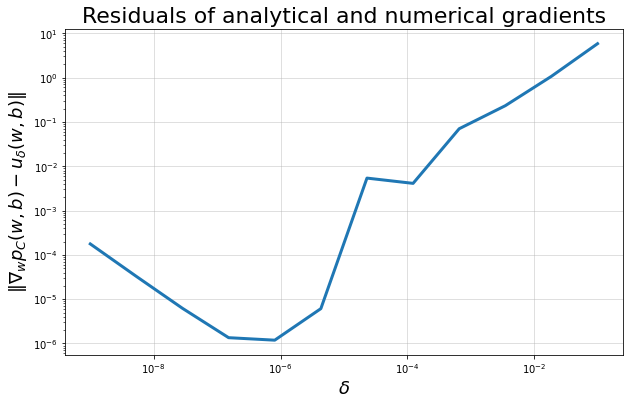

In [ ]:
# Q10
compare_gradients(X_train, Y_train, deltas=np.logspace(-9, -1, 12)) 

Q 11



max accuracy and min loss for lr = 0.001

max accuracy: 0.61
max accuracy iteration: 745

min loss: 81.499
min loss iteration: 2003


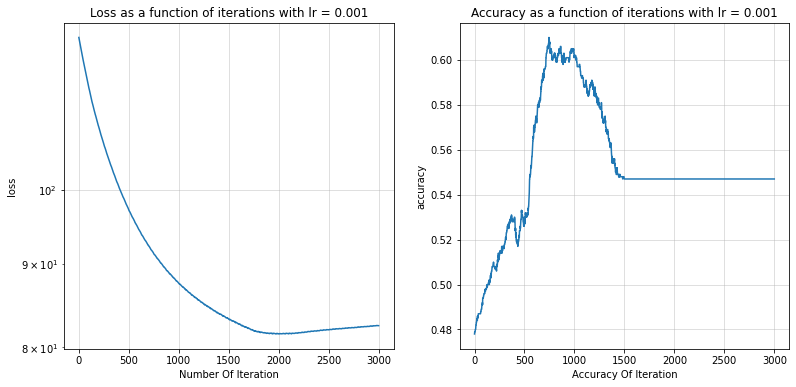

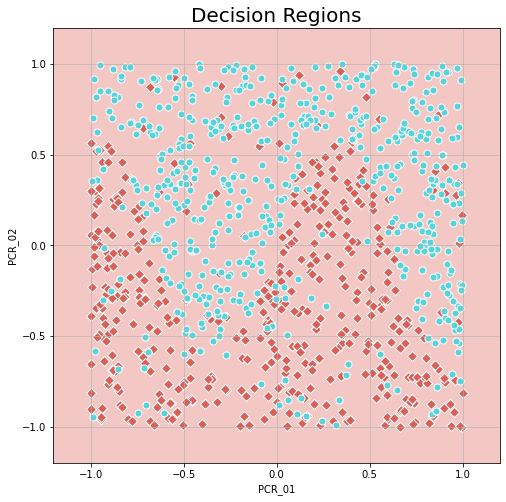



max accuracy and min loss for lr = 0.01

max accuracy: 0.656
max accuracy iteration: 50

min loss: 81.421
min loss iteration: 195


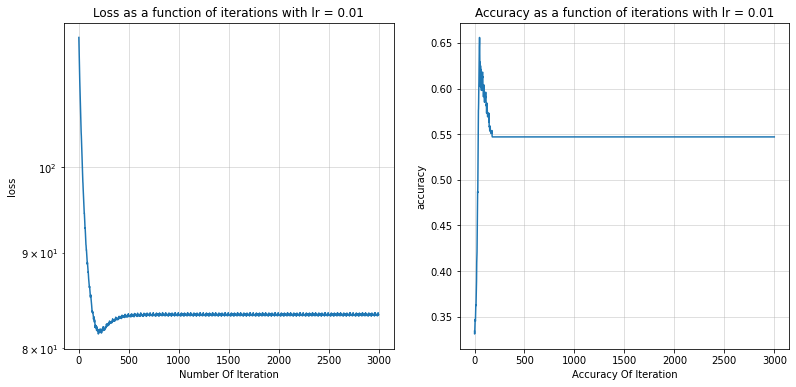

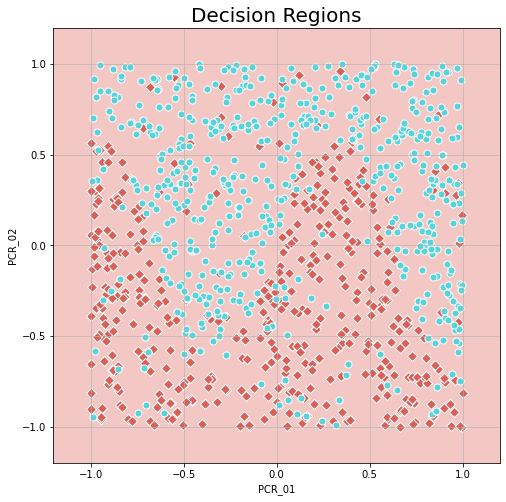



max accuracy and min loss for lr = 0.1

max accuracy: 0.736
max accuracy iteration: 7

min loss: 79.473
min loss iteration: 0


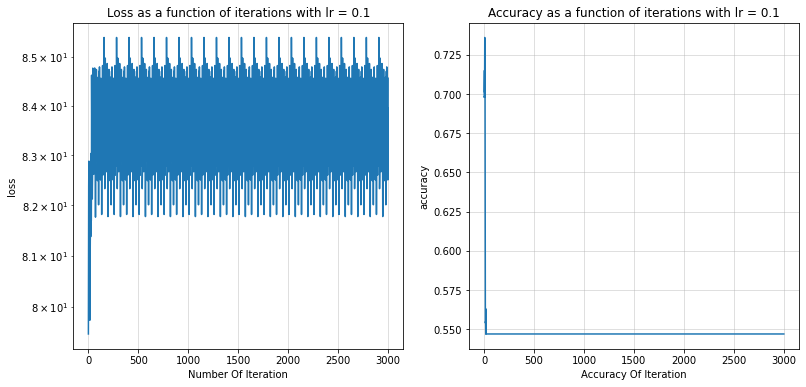

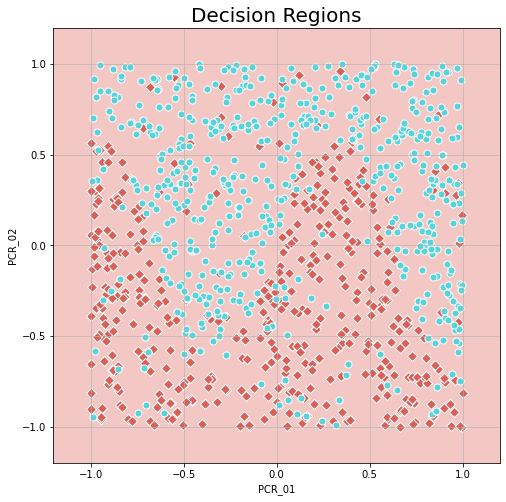



max accuracy and min loss for lr = 1.0

max accuracy: 0.645
max accuracy iteration: 1

min loss: 84.837
min loss iteration: 1


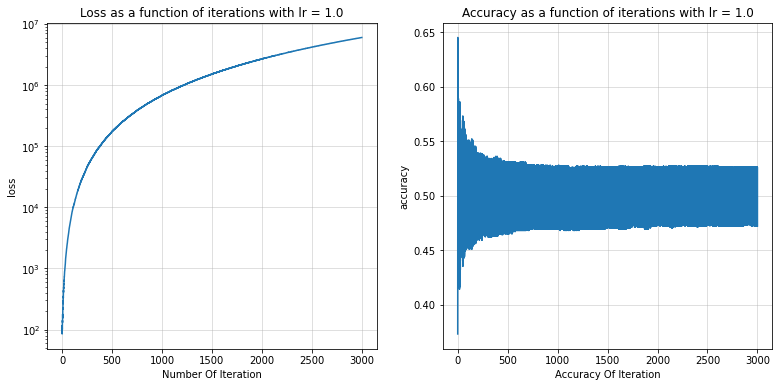

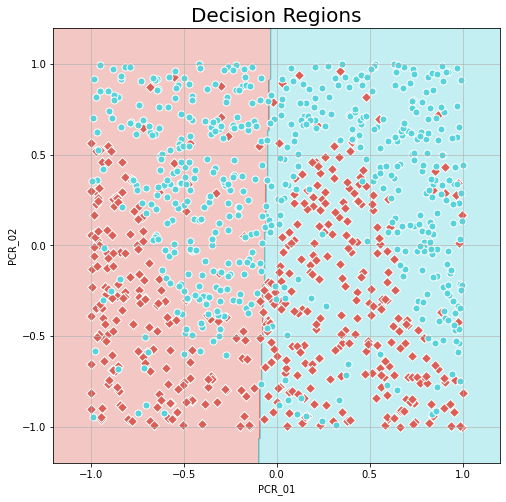

In [ ]:
# Q11
def SGD(lr):
  clf = SoftSVM(C=0.1, lr=lr)
  losses, accuracies = clf.fit_with_logs(X_train, Y_train, max_iter=3000)
  
  plt.figure(figsize=(13, 6))
  plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Loss as a function of iterations with lr = "+str(lr))
  plt.semilogy(losses), plt.xlabel("Number Of Iteration"), plt.ylabel("loss")
  plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Accuracy as a function of iterations with lr = "+str(lr))
  plt.plot(accuracies), plt.xlabel("Accuracy Of Iteration"), plt.ylabel("accuracy")

  print("\n\nmax accuracy and min loss for lr = "+str(lr))
  print('\nmax accuracy: {}'.format(np.max(accuracies)))
  print('max accuracy iteration: {}'.format(np.argmax(accuracies)))

  print('\nmin loss: {}'.format(np.round(np.min(losses), 3)))
  print('min loss iteration: {}'.format(np.argmin(losses)))

  visualize_clf(clf, X_train,Y_train,"Decision Regions","PCR_01","PCR_02")

lr_arr =  np.logspace(-3, 0, 4)
for lr in lr_arr:
  SGD(lr)

Q 12

In [ ]:
C = 1e13

def svm_clf_fun(deg, num_of_iter, X, Y):
  svm_clf = Pipeline([('feature_mapping', PolynomialFeatures(deg)), ('scaler', StandardScaler()), ('SVM', SoftSVM(C=C, lr=(1/(C*5e2))))]) 
  svm_clf.fit(X, Y, SVM__max_iter=10000)
  score = svm_clf.score(X, Y)
  s = 'SVM - feature mappings (PCR_01 & PCR_02), degree='+str(deg)+ ', iteration= ' + str(num_of_iter+1)
  visualize_clf(svm_clf, X, Y, s, 'PCR_01', 'PCR_02')
  print("Accuracies = " + str(score))
  return score


train :



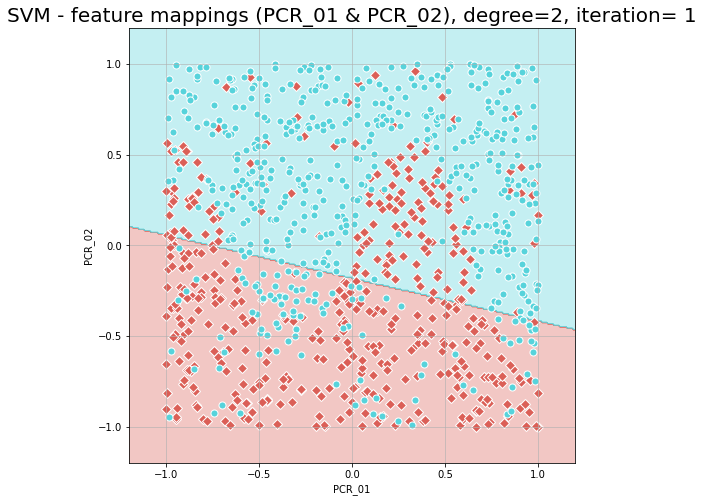

Accuracies = 0.732

test :



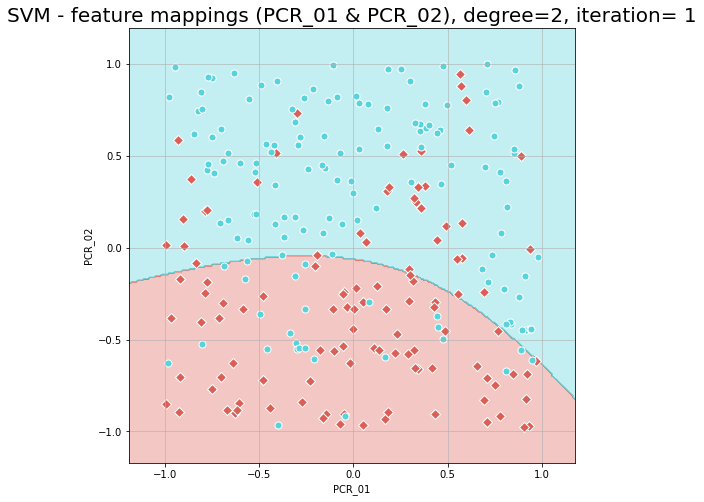

Accuracies = 0.748

train :



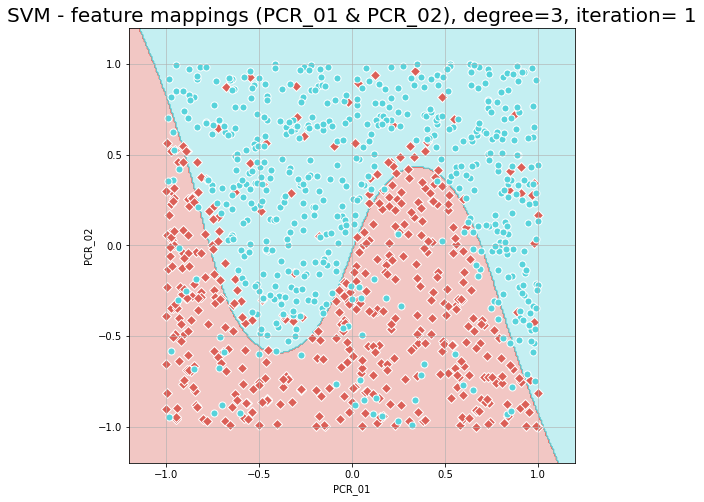

Accuracies = 0.85

test :



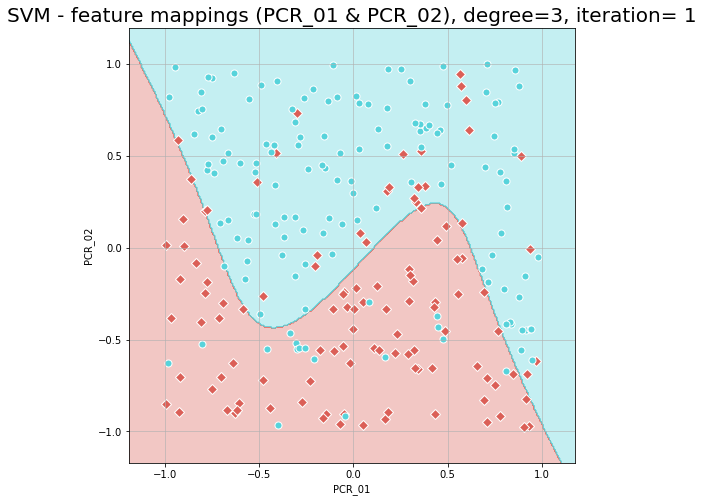

Accuracies = 0.816


0.816

In [ ]:
# Q12
print("\ntrain :\n")
svm_clf_fun(2,0,X_train,Y_train)
print("\ntest :\n")
svm_clf_fun(2,0, X_test, Y_test)

print("\ntrain :\n")
svm_clf_fun(3,0,X_train,Y_train)
print("\ntest :\n")
svm_clf_fun(3,0, X_test, Y_test)

Q 13

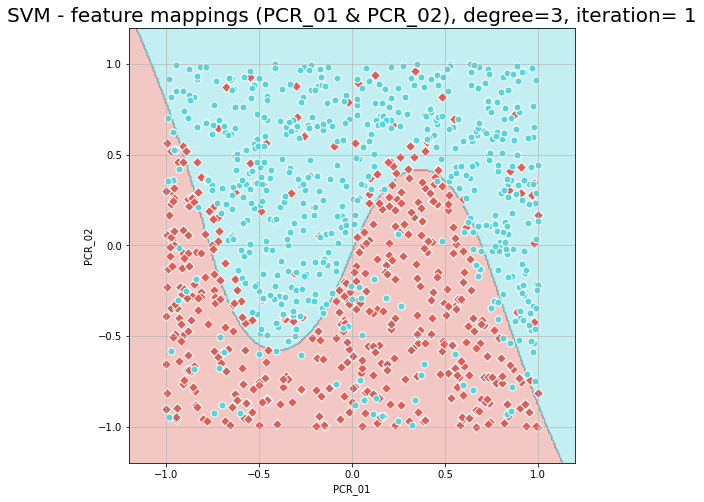

Accuracies = 0.849


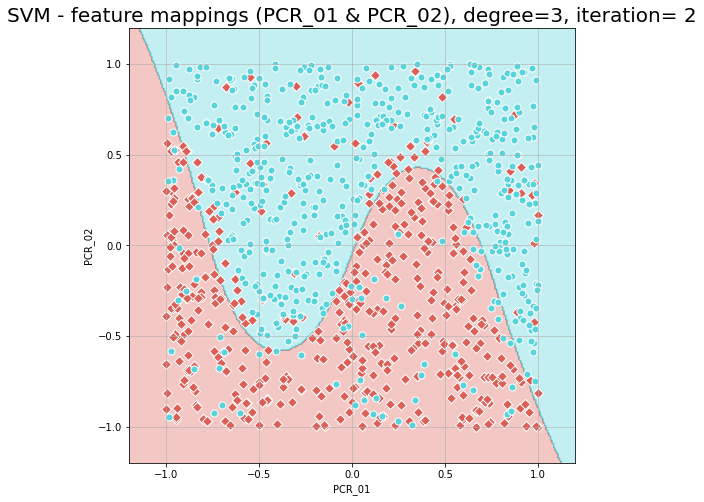

Accuracies = 0.851


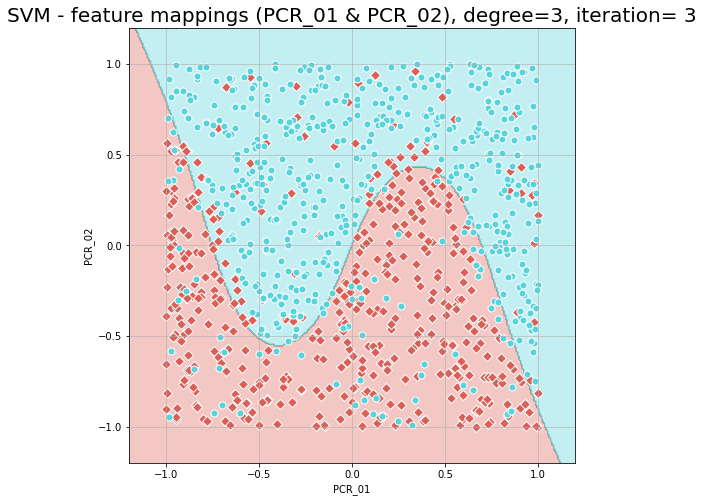

Accuracies = 0.85


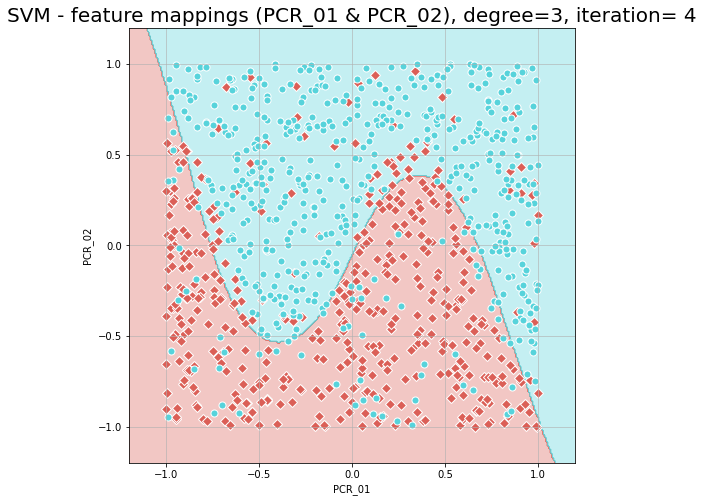

Accuracies = 0.852


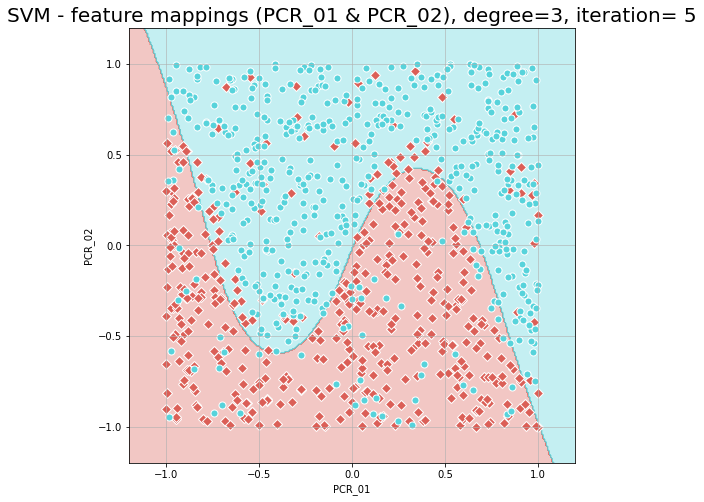

Accuracies = 0.85

Mean accuracy = 0.85
Standard deviation = 0.001


In [ ]:
# Q13 complete

scores = []
for i in range(5):
  scores.append(svm_clf_fun(3,i, X_train, Y_train))

result_arr = np.array(scores)
print("\nMean accuracy = " + str(np.round(mean(result_arr), 3)))
print("Standard deviation = " + str(np.round(std(result_arr), 3)))

PART 4

Q 14

Q 15

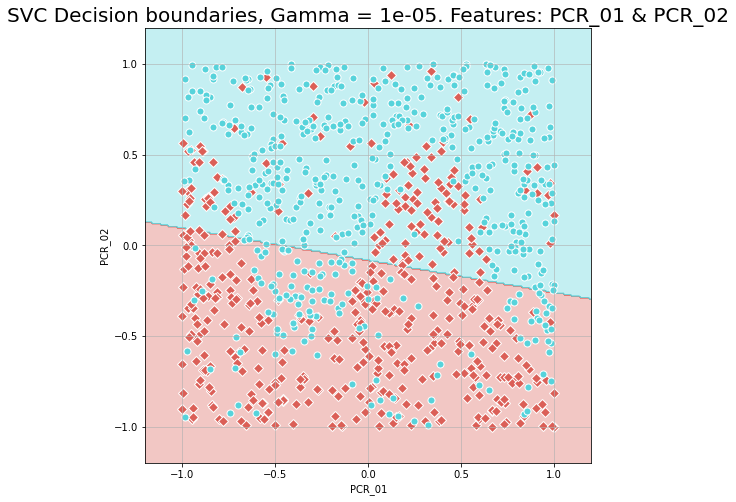

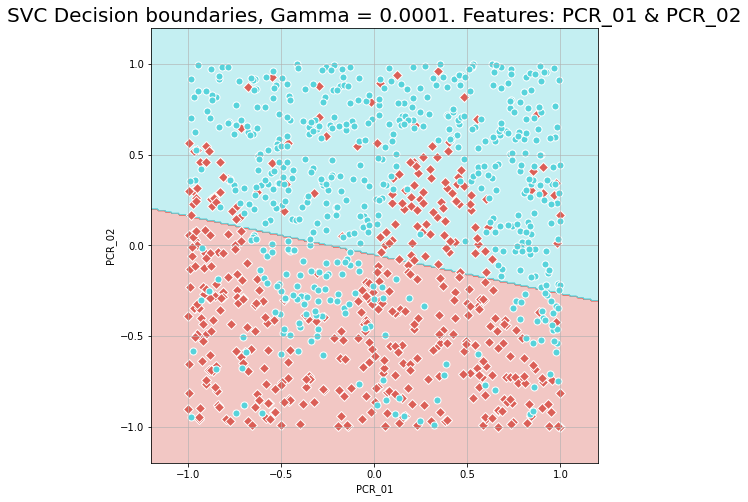

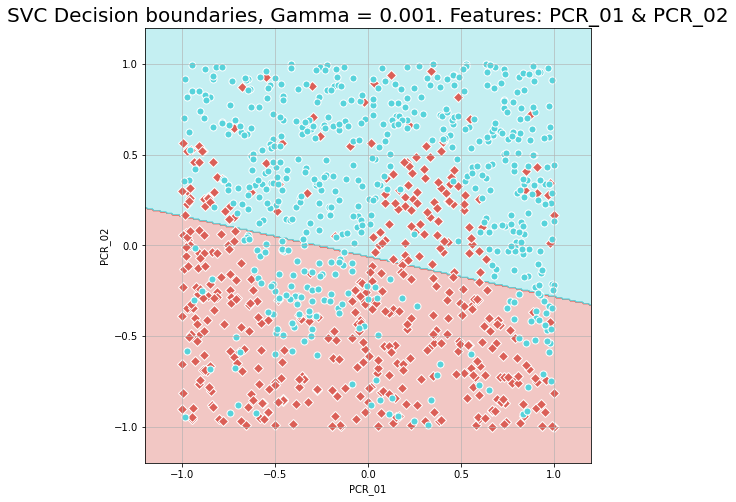

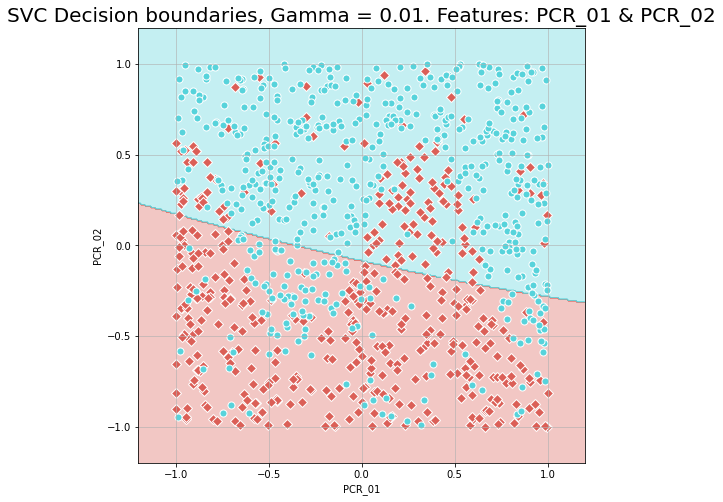

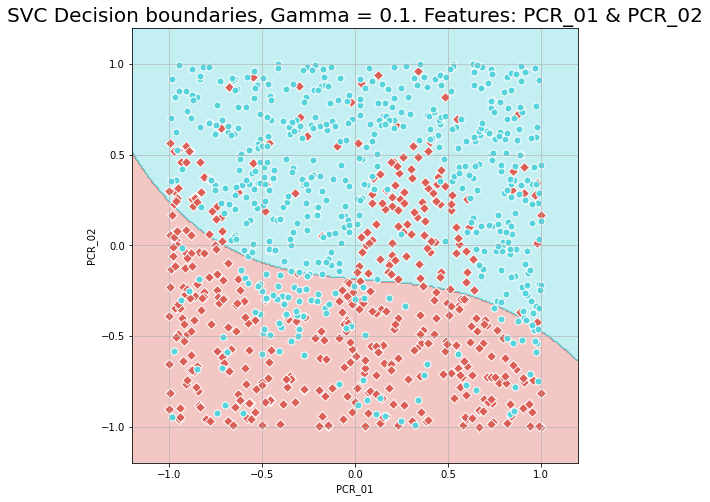

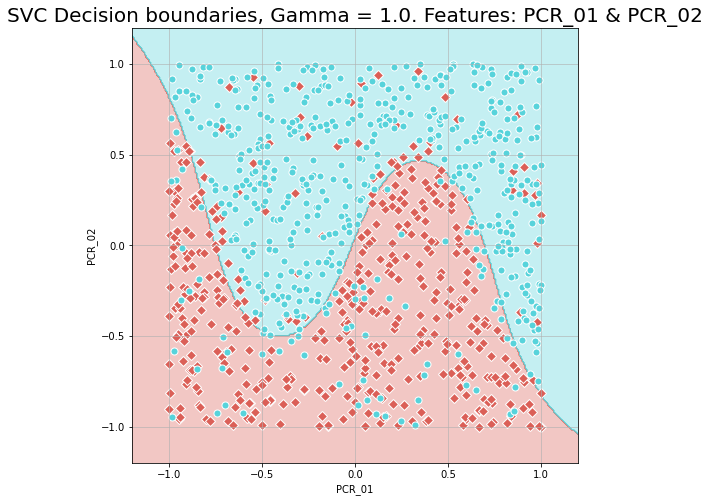

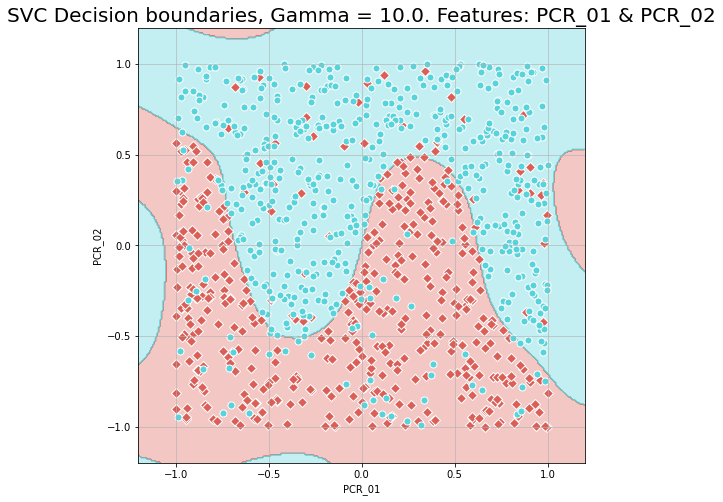

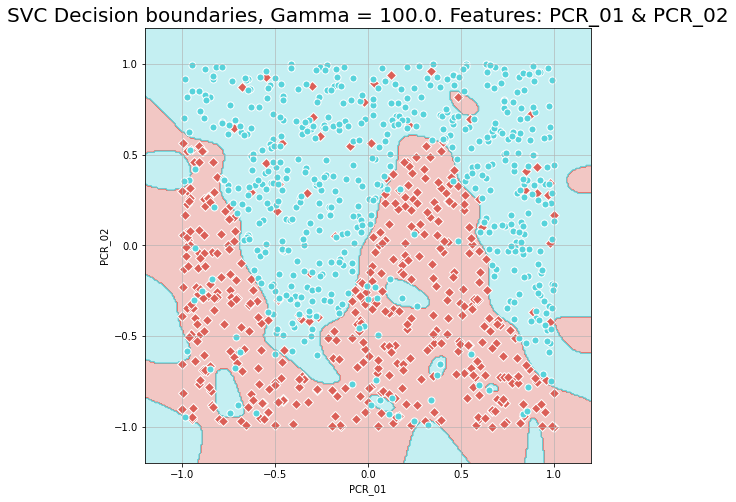

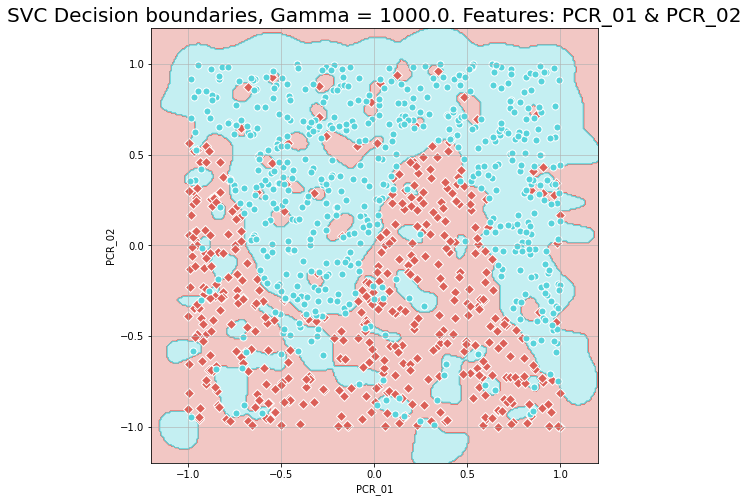

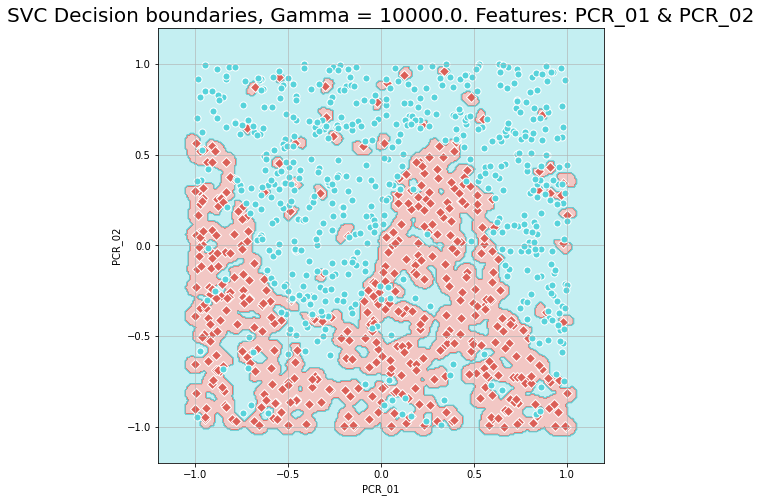

In [ ]:
#### Parp 4- The RBF kernel
# Q15

C = 1e4
for gamma in np.logspace(-5, 4, 10):
    clf = SVC(C=C, gamma=gamma/10, kernel='rbf')
    clf.fit(X_train, Y_train)
    result = clf.score(X_train, Y_train)
    visualize_clf(clf, X_train, Y_train, 'SVC Decision boundaries, Gamma = {}. Features: PCR_01 & PCR_02'.format(gamma), 'PCR_01', 'PCR_02', marker_size=50)

Q 17

In [ ]:
# Q17

param_dict = {'gamma': list(np.logspace(-2, 4, 7)), 'C': list(np.logspace(-1.0, 5.0, 7))}
grid = GridSearchCV(estimator=SVC(), param_grid=param_dict, cv=8, n_jobs=1, return_train_score=True)
_ = grid.fit(X_train, Y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'C': 10.0, 'gamma': 10.0}
Best score: 0.878


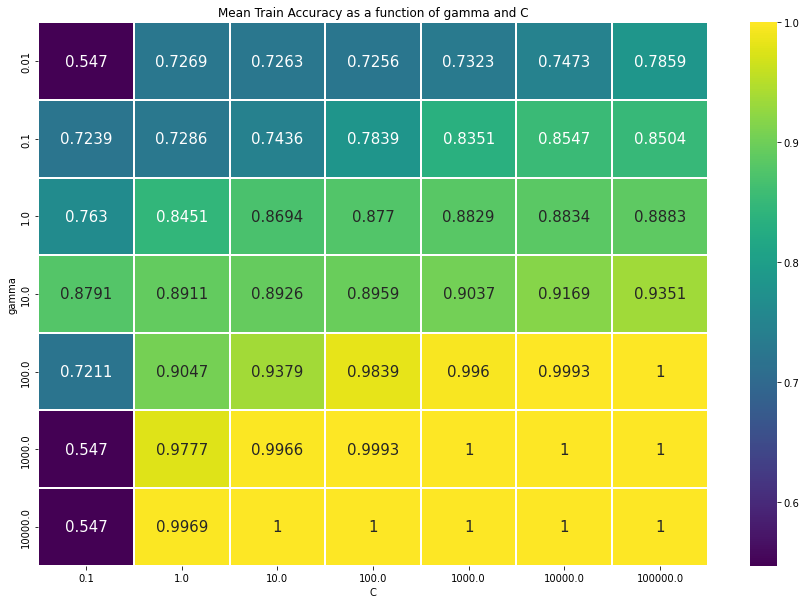

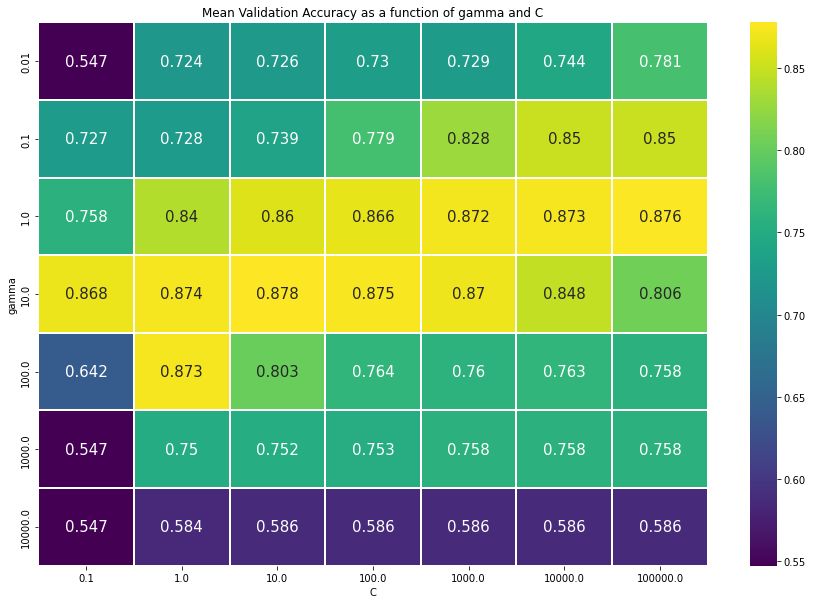

In [ ]:
tune_train = pd.pivot_table(pd.DataFrame(grid.cv_results_),
                            values='mean_train_score', index='param_gamma', columns='param_C')

fig, ax = plt.subplots(figsize=(15, 10))
train_subplot = sns.heatmap(tune_train, annot=True, linewidths=1, ax=ax, fmt='.4g', cmap='viridis',
                            annot_kws={'size': 15}, xticklabels=True, yticklabels=True)
plt.title("Mean Train Accuracy as a function of gamma and C")
plt.xlabel("C")
plt.ylabel("gamma")
plt.show()

tune_test = pd.pivot_table(pd.DataFrame(grid.cv_results_),
                                        values='mean_test_score', index='param_gamma', columns='param_C')

fig, ax = plt.subplots(figsize=(15, 10))
test_subplot = sns.heatmap(tune_test, annot=True, linewidths=1, ax=ax, fmt='.4g', cmap='viridis',
                           annot_kws={'size': 15}, xticklabels=True, yticklabels=True)
plt.title("Mean Validation Accuracy as a function of gamma and C")
plt.xlabel("C")
plt.ylabel("gamma")
plt.show()

Q 18

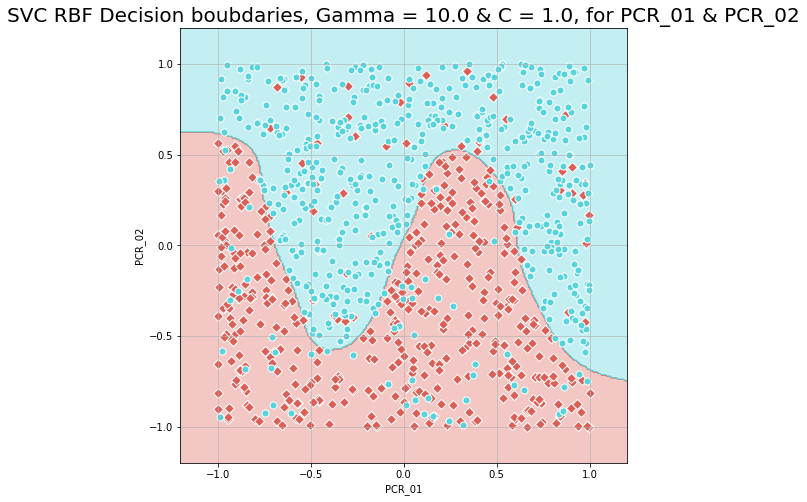

The test score of the SVC model with the best C and gamma is: 0.864


In [ ]:
# Q18
C = 1.0
gamma = 10.0
clf = SVC(C=C, gamma=gamma)
clf.fit(X_train, Y_train)
result = clf.score(X_test, Y_test)
s = 'SVC RBF Decision boubdaries, Gamma = ' + str(gamma) + ' & C = ' + str(C) + ', for PCR_01 & PCR_02'
visualize_clf(clf, X_train, Y_train, s, 'PCR_01', 'PCR_02')

print("The test score of the SVC model with the best C and gamma is: " + str(result))